# Loading raw data

In [ ]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
import pickle
import plotly.express as px
import streamlit as st

In [3]:
#load data
boston = pd.read_csv("C:/Users/Lenovo/OneDrive/Documents/Data Science/Projects/Boston House Prediction/boston.csv")

#display all columns
pd.set_option('display.max_columns', None)

boston.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


# Data Preparation

In [4]:
# split train test data

feature = boston.drop(columns='medv')
target = boston[['medv']]

#first split= pretrain and test
feature_boston_pretrain, feature_boston_test, target_boston_pretrain, target_boston_test = train_test_split(feature,
                                                                                                      target,
                                                                                                      test_size = 0.2,
                                                                                                      random_state=42)
#second split= train and validation
feature_boston_train, feature_boston_val, target_boston_train, target_boston_val = train_test_split(feature_boston_pretrain,
                                                                                                      target_boston_pretrain,
                                                                                                      test_size = 0.2,
                                                                                                      random_state=42)
feature_boston_train.shape, feature_boston_test.shape, feature_boston_val.shape

((323, 13), (102, 13), (81, 13))

In [5]:
#Column Selection
#calculate vif scores

#add constant for vif calculation
X = add_constant(feature_boston_train)

#calculating vif
vif_df = pd.DataFrame([vif(X.values, i)
                      for i in range(X.shape[1])],
                      index=X.columns).reset_index()

#rename columns
vif_df.columns = ['feature', 'vif_score']

#remove constant column (X)
vif_df = vif_df.loc[vif_df.feature != 'const']

vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


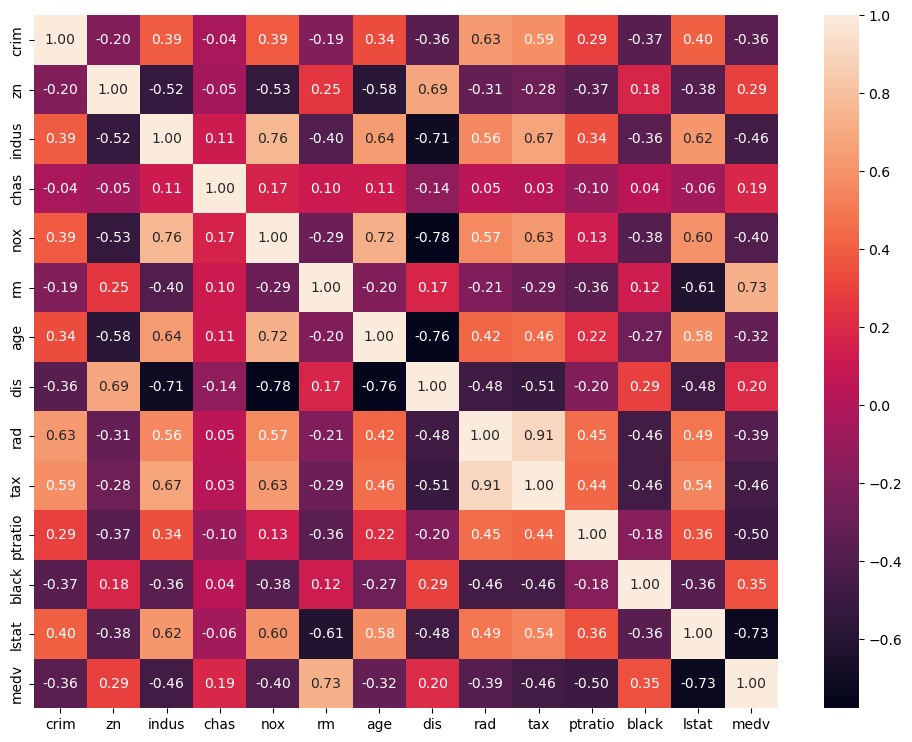

In [6]:
#heatmap correlation to drop unnecessary column

boston_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [7]:
#drop redundant features
feature_boston_train= feature_boston_train.drop(columns=['nox', 'dis', 'rad','tax'])
feature_boston_test= feature_boston_test.drop(columns=['nox', 'dis', 'rad','tax'])
feature_boston_val= feature_boston_val.drop(columns=['nox', 'dis', 'rad','tax'])

In [8]:
#recheck vif score

#add constant for vif calculation
X = add_constant(feature_boston_train)

#calculating vif
vif_df = pd.DataFrame([vif(X.values, i)
                      for i in range(X.shape[1])],
                      index=X.columns).reset_index()

#rename columns
vif_df.columns = ['feature', 'vif_score']

#remove constant column (X)
vif_df = vif_df.loc[vif_df.feature != 'const']

vif_df

,feature,vif_score
1,crim,1.361139
2,zn,1.760619
3,indus,2.334671
4,chas,1.078089
5,rm,1.876939
6,age,2.490305
7,ptratio,1.352767
8,black,1.290723
9,lstat,2.904905


# Modeling

In [9]:
#train model

#change data shape to fit the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

#model
ridge_10 = Ridge(alpha=10, random_state=42)

# fit model into training
ridge_10.fit(X_boston_train, y_boston_train)

Ridge(alpha=10, random_state=42)

In [10]:
#coefficient
final_ridge = ridge_10

ridgecoef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[final_ridge.intercept_] + list(final_ridge.coef_)
})

ridgecoef_df

,feature,coefficient
0,intercept,7.093462
1,crim,-0.053943
2,zn,-0.008202
3,indus,0.030609
4,chas,2.059544
5,rm,5.037204
6,age,0.020277
7,ptratio,-0.850631
8,black,0.012995
9,lstat,-0.541623


In [11]:
#All predict
final_feature = feature.drop(columns=['nox', 'dis', 'rad','tax'])
all_boston_predict = final_ridge.predict(final_feature)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [12]:
#Evaluation of model 
X_boston_test = feature_boston_test.to_numpy()
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

print('---------model evaluation---------')

#model 
print('---------test data model evaluation---------')
y_predict_test = final_ridge.predict(X_boston_test)
maetest = mean_absolute_error(y_boston_test, y_predict_test)
rmsetest = root_mean_squared_error(y_boston_test, y_predict_test)
mapetest = mean_absolute_percentage_error(y_boston_test, y_predict_test)*100
r2test = r2_score(y_boston_test, y_predict_test)*100

print(f'Ridge MAE for test data is {maetest:.2f}')
print(f'Ridge RMSE for test data is {rmsetest:.2f}')
print(f'Ridge MAPE for test data is {mapetest:.2f}%')
print(f'Ridge R2 for test data is {r2test:.2f}%')

#overfitting or underfitting?

#evaluate training data
print('---------train data model evaluation---------')
y_predict_train = final_ridge.predict(X_boston_train)
maetrain = mean_absolute_error(y_boston_train, y_predict_train)
rmsetrain = root_mean_squared_error(y_boston_train, y_predict_train)
mapetrain = mean_absolute_percentage_error(y_boston_train, y_predict_train)*100
r2train = r2_score(y_boston_train, y_predict_train)*100

print(f'Ridge MAE for train data is {maetrain:.2f}')
print(f'Ridge RMSE for train data is {rmsetrain:.2f}')
print(f'Ridge MAPE for train data is {mapetrain:.2f}%')
print(f'Ridge R2 for train data is {r2train:.2f}%')

print('---------model fitting detect---------')
if r2train - r2test > 15:
  print('the model is overfitting')
elif r2test < 50:
  print('the model is underfitting')
else:
  print('model is good to use')

---------model evaluation---------
---------test data model evaluation---------
Ridge MAE for test data is 3.38
Ridge RMSE for test data is 5.45
Ridge MAPE for test data is 18.24%
Ridge R2 for test data is 59.52%
---------train data model evaluation---------
Ridge MAE for train data is 3.53
Ridge RMSE for train data is 4.97
Ridge MAPE for train data is 17.47%
Ridge R2 for train data is 72.79%
---------model fitting detect---------
model is good to use


# Storing model and result

In [13]:
#store ML model
with open ('boston_linear_reg.pkl', 'wb') as f:
    pickle.dump(ridge_10, f)

In [17]:
#Drop columns that is not used 
final_boston = boston.drop(columns=['nox', 'dis', 'rad','tax'])
#Adding the predicted values
final_boston['price predictions'] = all_boston_predict

# Exporting all the data with predictions
final_boston.to_excel("boston_data_with_pred.xlsx")

# Streamlit app (deployement)

## Gathering inputs

In [20]:
final_feature.head()

,crim,zn,indus,chas,rm,age,ptratio,black,lstat
0,0.00632,18.0,2.31,0,6.575,65.2,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,6.421,78.9,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,7.185,61.1,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,6.998,45.8,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,7.147,54.2,18.7,396.90,5.33


In [21]:
final_feature.describe()

,crim,zn,indus,chas,rm,age,ptratio,black,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,6.284634,68.574901,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.702617,28.148861,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,3.561000,2.900000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,5.885500,45.025000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,6.208500,77.500000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,6.623500,94.075000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,8.780000,100.000000,22.000000,396.900000,37.970000


In [22]:
final_feature.columns

Index(['crim', 'zn', 'indus', 'chas', 'rm', 'age', 'ptratio', 'black',
       'lstat'],
      dtype='object')

In [23]:
#Function to gather all of data

#Feature selection on sidebar
def get_user_input():
    criminal_rate = st.sidebar.number_input('Criminal Rate (%)', min_value=0, max_value=100, step=1, value=0)
    proportion_of_resident = st.sidebar.number_input('Residential Land Zone Proportion (%)', min_value=0, max_value=100, step=1, value=0)
    industrial_proportion = st.sidebar.number_input('Non-Retail Business Acres Proportion (%)', min_value=0, max_value=100, step=1, value=0)
    river = st.sidebar.number_input('Bound to River? (1=Yes, 0=N))', min_value=0, max_value=1, step=1, value=0)
    rooms = st.sidebar.number_input('Number of Rooms Available', min_value=0, max_value=25, step=1, value=0)
    owner_age = st.sidebar.number_input('Owner Age Proportion', min_value=0, max_value=100, step=1, value=0)
    pupil_teacher = st.sidebar.number_input('Pupil-teacher Ratio', min_value=0, max_value=100, step=1, value=0)
    black_proportion = st.sidebar.number_input('Black Proportion', min_value=0, max_value=500, step=1, value=0)
    lower_status = st.sidebar.number_input('Population of Lower Status (%)', min_value=0, max_value=100, step=1, value=0)

    user_data={
        'crim' : criminal_rate,
        'zn' : proportion_of_resident,
        'indus' : industrial_proportion,
        'chas' : river,
        'rm' : rooms,
        'age' : owner_age,
        'ptratio' : pupil_teacher,
        'black' : black_proportion,
        'lstat' : lower_status,
    }
    return user_data

user_data = get_user_input()
user_data

2025-12-16 20:04:21.203 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 20:04:21.204 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 20:04:21.205 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 20:04:21.207 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 20:04:21.208 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-12-16 20:04:21.212 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

{'crim': 0,
 'zn': 0,
 'indus': 0,
 'chas': 0,
 'rm': 0,
 'age': 0,
 'ptratio': 0,
 'black': 0,
 'lstat': 0}

In [24]:
# Transforming the input into the required format
def prepare_input(data, feature_list):
    input_data = {feature: data.get(feature, 0) for feature in feature_list}
    return np.array([list(input_data.values())])

#feature list with the same order as training
features = ['crim', 'zn', 'indus', 'chas', 'rm', 'age', 'ptratio', 'black', 'lstat']

#array of inputs
input_array=prepare_input(user_data, features)
input_array

array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
#Making prediction
prediction = final_ridge.predict(input_array)
prediction

array([7.0934622])

In [ ]:
#Creating the app
import streamlit as st
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
from PIL import Image

#Page configuration
st.set_page_config(layout="wide")

#load pre-trained model
with open('boston_linear_reg.pkl', 'rb') as f:
    final_ridge2=pickle.load(f)

#sidebar setup
image_sidebar = Image.open('boston side bar.jpg')
st.sidebar.image(image_sidebar, use_column_width=True)
st.sidebar.header('Boston House Features')

#feature selection on sidebar
def get_user_input():
    criminal_rate = st.sidebar.number_input('Criminal Rate (%)', min_value=0, max_value=100, step=1, value=0)
    proportion_of_resident = st.sidebar.number_input('Residential Land Zone Proportion (%)', min_value=0, max_value=100, step=1, value=0)
    industrial_proportion = st.sidebar.number_input('Non-Retail Business Acres Proportion (%)', min_value=0, max_value=100, step=1, value=0)
    river = st.sidebar.number_input('Bound to River? (1=Yes, 0=N))', min_value=0, max_value=1, step=1, value=0)
    rooms = st.sidebar.number_input('Number of Rooms Available', min_value=0, max_value=25, step=1, value=0)
    owner_age = st.sidebar.number_input('Owner Age Proportion', min_value=0, max_value=100, step=1, value=0)
    pupil_teacher = st.sidebar.number_input('Pupil-teacher Ratio', min_value=0, max_value=100, step=1, value=0)
    black_proportion = st.sidebar.number_input('Black Proportion', min_value=0, max_value=500, step=1, value=0)
    lower_status = st.sidebar.number_input('Population of Lower Status (%)', min_value=0, max_value=100, step=1, value=0)

    user_data={
        'crim' : criminal_rate,
        'zn' : proportion_of_resident,
        'indus' : industrial_proportion,
        'chas' : river,
        'rm' : rooms,
        'age' : owner_age,
        'ptratio' : pupil_teacher,
        'black' : black_proportion,
        'lstat' : lower_status,
    }
    return user_data

#top banner
image_banner= Image.open('boston top.jpg')
st.image(image_banner, use_column_width=True)

#centered title
st.markdown("<h1 style='text-align: center;'>Boston House Price Prediction App</h1>", unsafe_allow_html=True)

#make columns in page
pred_col = st.columns(1)

#prediction
with pred_col:
    st.header("Predict House Price")

    #user input from sidebar
    user_data=get_user_input()

    # Transforming the input into the required format
    def prepare_input(data, feature_list):
        input_data = {feature: data.get(feature, 0) for feature in feature_list}
        return np.array([list(input_data.values())])

    #feature list with the same order as training
    features = ['crim', 'zn', 'indus', 'chas', 'rm', 'age', 'ptratio', 'black', 'lstat']

    #predict button
    if st.button("Predict"):
        input_array=prepare_input(user_data, features)
        prediction = final_ridge2.predict(input_array)
        st.subheader("Predict Price")
        st.write(f"${prediction[0]:,.2f}")

#streamlit run model